In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm

import numpy as np
import pandas as pd
import re, os, sys

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
mpl.rcParams['pdf.fonttype'] = 42

import math

font_name = {'fontname':'Arial'}

plt.rcParams["font.family"] = "Arial"

import joblib

import cptac

In [2]:
dataset = cptac.list_datasets()

# get names of data sets
names = list(dataset.index)
names

['Brca',
 'Ccrcc',
 'Colon',
 'Endometrial',
 'Gbm',
 'Hnscc',
 'Lscc',
 'Luad',
 'Ovarian',
 'Pdac',
 'UcecConf',
 'GbmConf']

In [3]:
projects = {
    'Brca': cptac.Brca,
    'Ccrcc': cptac.Ccrcc,
    'Colon': cptac.Colon,
    'Endometrial': cptac.Endometrial,
    'Gbm': cptac.Gbm,
    'Hnscc': cptac.Hnscc,
    'Lscc': cptac.Lscc,
    'Luad': cptac.Luad,
    'Ovarian': cptac.Ovarian,
    'Pdac': cptac.Pdac,
}

In [4]:
# get proteome tables of each cohort
proteomes = dict()
for i in projects.keys():
    cptac.download(dataset=i)
    p = projects.get(i)()
    proteome = p.get_proteomics()
    proteomes[i] = proteome

cptac warning: Your version of cptac (1.1.2) is out-of-date. Latest is 1.5.7. Please run 'pip install --upgrade cptac' to update it. (/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/threading.py, line 910)


/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/site-packages/cptac/colon.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prot_combined = prot_tumor.append(prot_normal)
/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/site-packages/cptac/colon.py:153: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  phos_combined = phos_tumor.append(phos_normal)


In [9]:
def get_pdac_samples():

    GPNotebook_dir = r"/Users/yingweihu/Documents/GitHub/GPNotebook"
    data_name = "PDAC"

    wd = os.path.join(GPNotebook_dir,"sample",data_name)


    # input meta path: standardrized meta table
    meta_path = os.path.join(wd,"meta/info.tsv")
    
    meta_dir = os.path.join(wd,"meta") 
    sample_path = os.path.join(meta_dir, "Supplementary_table_1_v3.0.xlsx")

    # load meta data
    meta_df = pd.read_csv(meta_path,sep="\t")
    meta_df.head(10)
    
    tumor_samples = []
    nat_samples = []

    # read sample names
    sample_df = pd.read_excel(sample_path,sheet_name="PDAC")

    nd_samples = []

    for index,row in sample_df.iterrows():
        status = row['Pathological.Status']
        sample = row['Sample.ID']
    #     print(sample)
        if re.sub('PDA.','',sample) not in set(meta_df['Sample']) and status != 'Normal-duct':
            continue
        if status == "Tumor":
            tumor_samples.append(sample)
        elif status == 'NAT':
            nat_samples.append(sample)
        elif status == "Normal-duct":
            nd_samples.append(sample)
        else:
            print(sample)
            
    result = {
        'tumor': tumor_samples,
        'normal_adjcent': nat_samples,
        'normal_duct': nd_samples
    }
    return result

In [10]:
from omicsone.plugins.diff import compare_two_groups

diffs = dict()
for name in proteomes.keys():
    # get protein expression dataframe
    proteome_df = proteomes[name].T
    # tumor_samples = get_tumor_samples(name)
    # nat_samples = get_nat_samples(name)
    # get meta table
    p = projects.get(name)()

    clinical = p.get_clinical()
    if name == "Brca":
        continue
    elif name in ["Ccrcc",'Colon', 'Endometrial', 'Gbm', 'Hnscc', 'Lscc', 'Luad', 'Ovarian']:
        tumor_samples = list(clinical[clinical['Sample_Tumor_Normal']=="Tumor"].index)
        nat_samples = list(clinical[clinical['Sample_Tumor_Normal']=="Normal"].index)
        print(name,len(tumor_samples),len(nat_samples))
        tumor_samples = [i for i in tumor_samples if i in proteome_df.columns.values]
        nat_samples = [i for i in nat_samples if i in proteome_df.columns.values]
        print(name, len(tumor_samples), len(nat_samples))
    if name == 'Pdac':
        samples = get_pdac_samples()
        tumor_samples = [i.split('.')[1] for i in samples['tumor']]
        nat_samples = ['.'.join(i.split('.')[1:]) for i in samples['normal_adjcent']]
#         tumor_samples = list(pdac_meta[pdac_meta['tumor_included_for_the_study'] == 'yes']['Patient_ID'])
#         nat_samples = list(pdac_meta[pdac_meta['normal_included_for_the_study'] == 'yes']['Patient_ID'])
#         nat_samples = [i + '.N' for i in nat_samples if i + ".N" in proteome_df.columns.values]
#         supplement_path = pdac_dir + os.sep + "PDAC_Tumor_and_NAT_samples_for_data_freeze_20200622_sortYHU39.xlsx"
#         map_df = pd.read_excel(supplement_path, sheet_name="Normal duct samples")
#         nd_samples = [i for i in map_df['CPTAC Participant ID']]
    # calculate differential expression
    diff_df = compare_two_groups(proteome_df,tumor_samples,nat_samples,method= 'Wilcoxon(Unpaired)', fdr_cutoff=0.01, log2fc_cutoff=1,
                       max_miss_ratio_global=0.5, max_miss_ratio_group=0.5, min_sample_size=4)
    diffs[name] = diff_df


Ccrcc 110 84                              
Ccrcc 110 84


11710it [00:08, 1439.19it/s]


/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/site-packages/cptac/colon.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prot_combined = prot_tumor.append(prot_normal)
/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/site-packages/cptac/colon.py:153: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  phos_combined = phos_tumor.append(phos_normal)


                        
Colon 110 100
Colon 97 100


8067it [00:05, 1410.24it/s]


Endometrial 95 49                               
Endometrial 95 49


10999it [00:07, 1443.17it/s]


Gbm 105 10                              
Gbm 99 10


11141it [00:07, 1396.69it/s]


Hnscc 111 81                              
Hnscc 109 69


11744it [00:08, 1436.17it/s]


Lscc 116 103                             
Lscc 108 99


11575it [00:09, 1205.01it/s]


Luad 110 101                             
Luad 110 101


10699it [00:08, 1219.42it/s]


Ovarian 111 20                              
Ovarian 83 20


10686it [00:07, 1426.50it/s]


11662it [00:07, 1503.59it/s]


In [11]:
for name in diffs:
    diff_df = diffs[name]
    if name in ['Ccrcc','Lscc','Luad','Ovarian']:
        print(name,diff_df.shape)
        diff_df.index = [i[0] for i in diff_df.index]
        diff_df = diff_df.groupby(diff_df.index).median()
        diffs[name] = diff_df
        print(name,diff_df.shape)

Ccrcc (8985, 7)
Ccrcc (8780, 6)
Lscc (11149, 7)
Lscc (10704, 6)
Luad (10254, 7)
Luad (9875, 6)
Ovarian (9780, 7)
Ovarian (9185, 6)


<ipython-input-11-12544140d93b>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff_df = diff_df.groupby(diff_df.index).median()
<ipython-input-11-12544140d93b>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff_df = diff_df.groupby(diff_df.index).median()
<ipython-input-11-12544140d93b>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff_df = diff_df.groupby(diff_df.index).median()
<ipython-input-11-1254

In [16]:
genes = dict()
genes['Ccrcc'] = set([i[0] for i in diffs['Ccrcc'].index])
genes['Colon'] = set(diffs['Colon'].index)
genes['Endometrial'] = set(diffs['Endometrial'].index)
genes['Gbm'] = set(diffs['Gbm'].index)
genes['Hnscc'] = set(diffs['Hnscc'].index)
genes['Lscc'] = set([i[0] for i in diffs['Lscc'].index])
genes['Luad'] = set([i[0] for i in diffs['Luad'].index])
genes['Ovarian'] = set([i[0] for i in diffs['Ovarian'].index])
genes['Pdac'] = set(diffs['Pdac'].index)

In [17]:
genes_all = set(genes['Ccrcc']) | set(genes['Colon']) | set(genes['Endometrial']) | set(genes['Gbm']) | set(genes['Hnscc']) | set(genes['Lscc']) | set(genes['Luad']) | set(genes['Ovarian']) | set(genes['Pdac'])

In [19]:
enzyme_path = r'N-LINKED_PATHWAY_STEPS_2022_YHU.xlsx'
# enzyme_path = r"N-LINKED_PATHWAY_STEPS_2015.xlsx"
enzyme_df = pd.read_excel(enzyme_path,engine='openpyxl')
enzyme_df

/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,PATH,PROTEIN,STEP,Monosaccharide
0,LLO,ALG5,1,Glucose
1,LLO,DPM1,2,Mannose
2,LLO,DPM2,2,Mannose
3,LLO,DPM3,2,Mannose
4,LLO,DOLK,3,NaN
...,...,...,...,...
123,Common,B3GALNT2,25,GalNAc
124,Common,B3GALT4,26,Galactose
125,Common,B3GALT5,26,Galactose
126,Common,CHST8,27,SO4


In [21]:
enzyme_proteins = list(enzyme_df['PROTEIN'])
glycogene_order = [i for i in enzyme_proteins if i in genes_all]
len(enzyme_proteins), len(glycogene_order)

(128, 85)

In [22]:
rows = []
for i in glycogene_order:
    row = []
    for name in sorted(list(diffs.keys())):
        diff_df = diffs[name]
        if i in diff_df.index:
            log2FC = diff_df[diff_df.index == i].iloc[0]['Log2FC(median)']
        else:
            log2FC = np.nan
        row.append(log2FC)
    rows.append(row)
result = pd.DataFrame(rows,columns=sorted(list(diffs.keys())),index=glycogene_order)

<AxesSubplot:>

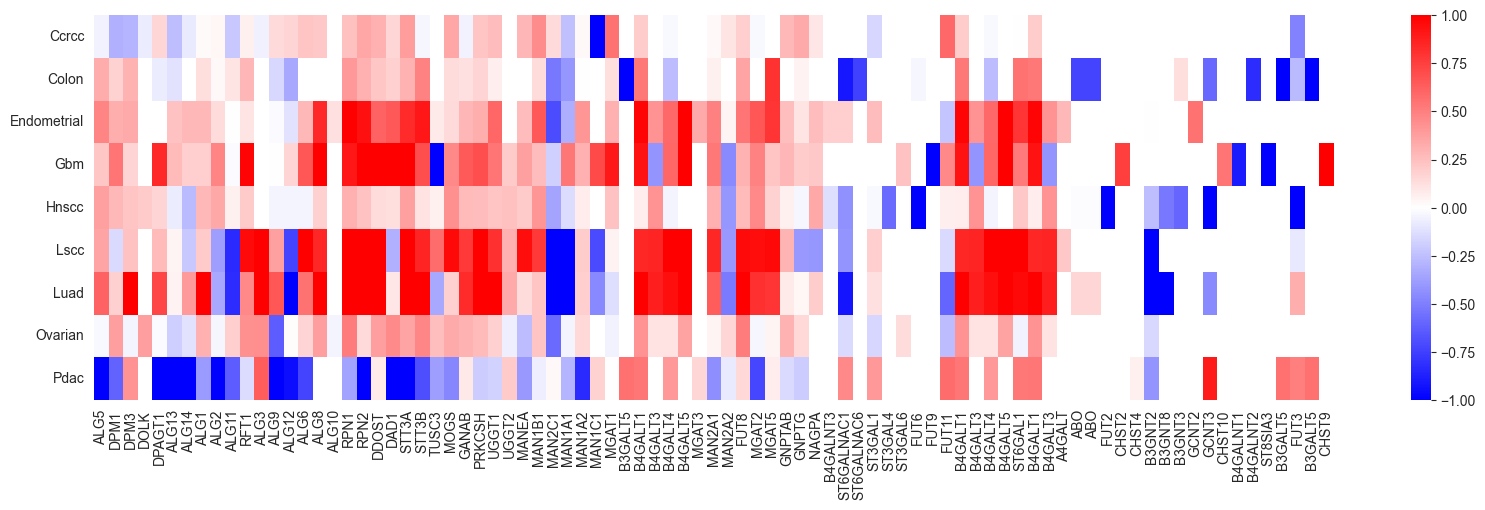

In [23]:
fig,ax = plt.subplots(figsize=(20,5))
sns.heatmap(data=result.T,cmap='bwr',vmin=-1,vmax=1)